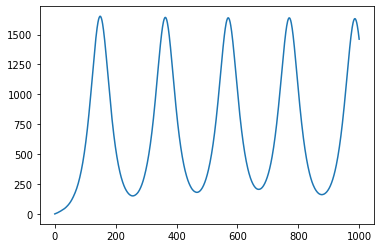

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from DAmethod.EnKF import EnKF

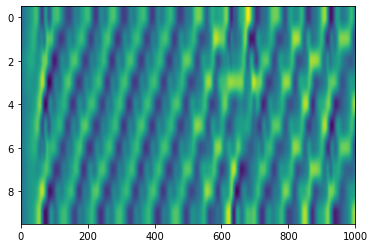

In [3]:
from dynamicalsystems.lorenz93 import Lorenz93Model

# Set class variable
state_dimension = 10
Lorenz93Model.dim = state_dimension
lorenz40 = Lorenz93Model()
x0 = np.random.normal(0, 1, lorenz40.dim)
lorenz40.set_initial_state(0, x0)
lorenz40.forward(1000)
plt.imshow(lorenz40.state_vector, aspect="auto")
plt.show()

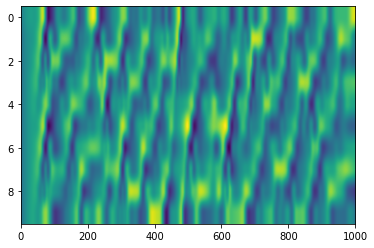

In [4]:
truth = Lorenz93Model()
x0 = np.zeros(state_dimension)
x0[0] = 1
truth.set_initial_state(-1000 * truth.dt, x0)
truth.forward(1000)
plt.imshow(truth.state_vector, aspect="auto")
plt.show()

In [5]:
def create_projector(n, m, indices):
    H = np.zeros((m, n))
    for i in indices:
        H[i, i] = 1
    return H

In [6]:
period_assim = 1
sigobs = 1
Nensemble = 20
dim_observations = 3#state_dimension 
H = create_projector(state_dimension, dim_observations, np.arange(dim_observations))
R = sigobs * np.eye(dim_observations)
inflation_factor=1.05

In [7]:
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(state_dimension) * sigobs
    return truth.t[-1], y

In [14]:
enkf = EnKF(state_dimension, Nensemble, R, inflation_factor)
enkf.set_forwardmodel(lambda x: Lorenz93Model.integrate(0, x, period_assim,)[1][:, -1])
enkf.H = H
siginit = 0.2
initial_state = truth.state_vector[:, -1]
covariance = siginit * np.eye(state_dimension)
enkf.generate_ensemble(mean=initial_state, cov=covariance)
Yf, Yfhat = enkf.normalised_anomalies()
Yfhat.shape

AttributeError: 'EnKF' object has no attribute 'normalised_anomalies'

In [9]:
Nsteps = 1000
dEnKF = enkf.run(Nsteps, generate_observations)
# print(f"Xf: {enkf.normalised_anomalies().shape=}")
# print(f"Yf: {enkf.observation_anomalies().shape=}")
# T, T2 = enkf.compute_transform()
# print(f"T : {T.shape=}")

c:\Users\a846735\DA_sandbox\dynamicalsystems\lorenz93.py:25: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i + 1) % cls.dim] - x[i - 2]) * x[i - 1] - x[i] + 8
c:\Users\a846735\DA_sandbox\dynamicalsystems\lorenz93.py:25: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i + 1) % cls.dim] - x[i - 2]) * x[i - 1] - x[i] + 8
c:\Users\a846735\DA_sandbox\solvers\solvers.py:24: RuntimeWarning: invalid value encountered in add
  return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


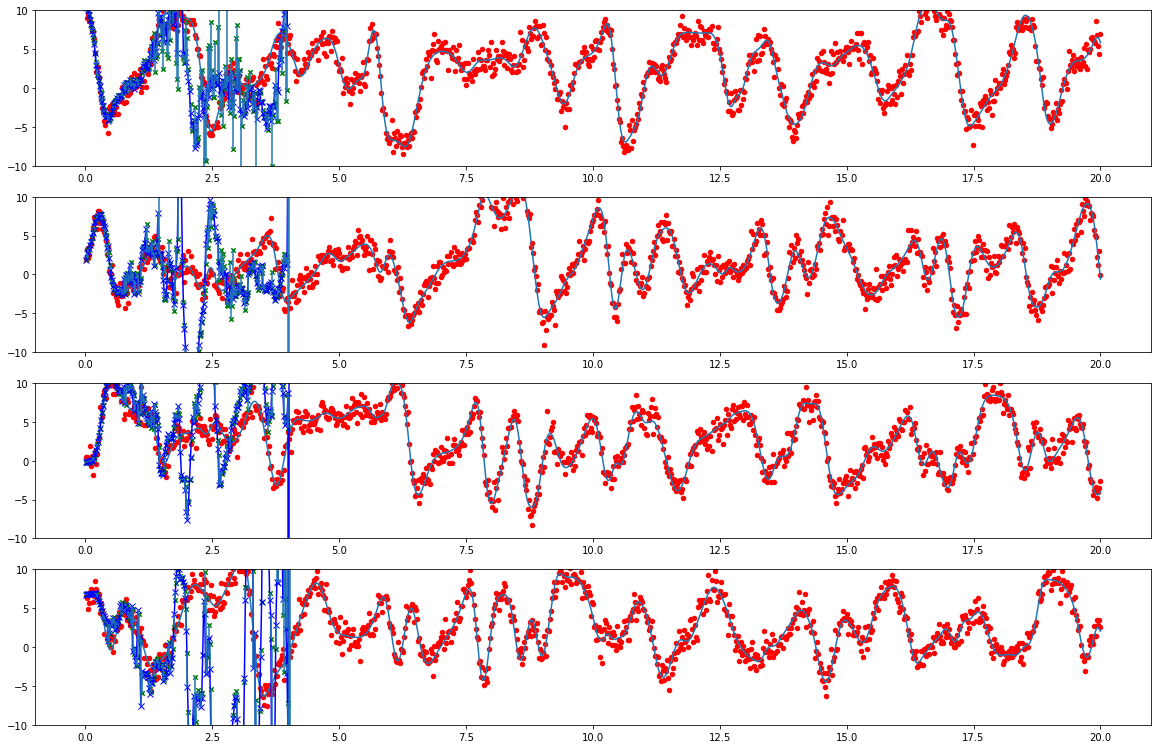

In [10]:
obs_ = np.array(dEnKF["observations"])
xf = np.asarray(dEnKF['ensemble_f'])
xfbar = xf.mean(2)
xa = np.asarray(dEnKF['ensemble_a'])
xabar= xa.mean(2)
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(6, 1, i + 1)
    plt.plot(truth.t[1001:], truth.state_vector[i, 1001:])
    plt.scatter(dEnKF["time"], obs_[:, i], marker="o", c="red", s=20)
    plt.scatter(dEnKF["time"], xfbar[:, i], marker="x", color="green", s=20)
    plt.plot(dEnKF["time"], xabar[:, i], "x-", color="blue")
    plt.vlines(dEnKF["time"], xfbar[:, i], xabar[:, i])
    plt.ylim([-10, 10])
plt.show()

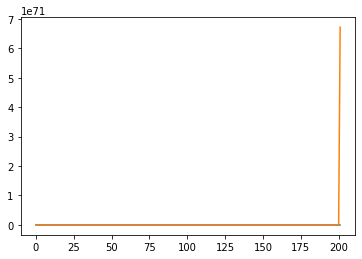

In [11]:
xa_var = xa.var(2)
xf_var = xf.var(2)
plt.plot(xa_var[:, 0])
plt.plot(xf_var[:, 0])

In [12]:
np.isclose(xfbar,xabar).all()

False

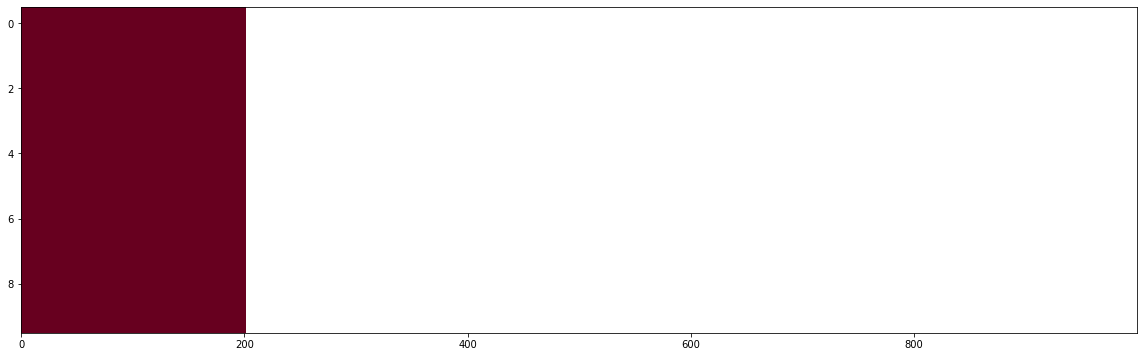

In [13]:
analysis_error = truth.state_vector[:, 1001::period_assim] - np.real(xabar.T)
mi, ma = analysis_error.min(), analysis_error.max()
lim = max(np.abs(mi), np.abs(ma))
plt.figure(figsize=(20, 6))
plt.imshow(analysis_error, vmin=-lim, vmax=lim, cmap='RdBu', aspect='auto')